In [1]:
import numpy as np
import pandas as pd
from typing import List
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os 
import scipy.ndimage
import netCDF4 as nc
from sklearn.model_selection import train_test_split

Create a X Design matrix made in shape (400*600, 24)
when each row is a grid point and each feature is a model.

In [2]:
def flatten_models_to_grid_matrix(interpolated_precip_list: List[np.ndarray]) -> np.ndarray:
    """
    Create a design matrix X where each row represents a grid point, and each column 
    (feature) represents the flattened precipitation data from a different model.

    Parameters:
    -----------
    interpolated_precip_list : List[np.ndarray]
        A list of 2D arrays (matrices) with dimensions (400, 600) representing 
        precipitation data from different models. Each matrix corresponds to a different 
        model.

    Returns:
    --------
    np.ndarray
        A 2D array (design matrix X) of shape (240000, num_models), where:
        - Each row corresponds to a specific grid point across all models.
        - Each column corresponds to the precipitation data for that grid point from 
          a particular model.
    """
    
    # Number of models and number of grid points
    num_models = len(interpolated_precip_list)
    num_grid_points = 400 * 600

    # Initialize an empty matrix to store the reshaped data
    X = np.zeros((num_grid_points, num_models))

    # Loop over each model's matrix and reshape it into a vector
    for i, precip_matrix in enumerate(interpolated_precip_list):
        # Reshape each (400, 600) matrix to (240000,) and assign it to the ith column
        X[:, i] = precip_matrix.reshape(-1)

    return X

In [3]:
# Function to interpolate to target dimensions
def extrarpolate_to_target_dim(data, target_dim):
    m, n = data.shape[1:]  # Original dimensions
    interpolated_data = np.empty((data.shape[0], target_dim[0], target_dim[1]))  # Create an empty array to hold the results

    for i in range(data.shape[0]):  # Iterate over the time dimension
        interpolator = scipy.interpolate.RegularGridInterpolator(
            (np.linspace(0, 1, m), np.linspace(0, 1, n)), 
            data[i, :, :], 
            method='linear'
        )
        new_x = np.linspace(0, 1, target_dim[0])
        new_y = np.linspace(0, 1, target_dim[1])
        new_grid_x, new_grid_y = np.meshgrid(new_x, new_y, indexing='ij')
        points = np.stack([new_grid_x.ravel(), new_grid_y.ravel()], axis=-1)
        interpolated_slice = interpolator(points).reshape(target_dim)
        interpolated_data[i, :, :] = interpolated_slice
    return interpolated_data

In [4]:
def get_chirps_data(chirps_path:str):
    chirps_dataset = nc.Dataset(chirps_path) 
    chirps_precip_data = np.array(chirps_dataset.variables['precip'][:])
    chirps_2D = np.mean(chirps_precip_data,axis=0)
    return chirps_2D

In [5]:
data_relative_path = os.path.join('..', 'Data')
ERA5_PATH = os.path.join(data_relative_path,'ERA5')
CHIRPS_DIR_PATH = os.path.join(data_relative_path,'CHIRPS2')
CHIRPS_DATA_PATH = os.path.join(CHIRPS_DIR_PATH,"chirps_octobers_middle_east_1981_2010.nc")

In [6]:
# Function to find the indices that match the latitude and longitude bounds
def find_lat_lon_indices(latitude, longitude, bounds_lat, bounds_lon):
    lat_indices = np.where((latitude >= bounds_lat[0]) & (latitude <= bounds_lat[1]))[0]
    lon_indices = np.where((longitude >= bounds_lon[0]) & (longitude <= bounds_lon[1]))[0]
    return lat_indices, lon_indices

# Function to interpolate the data to target dimensions
def extrapolate_to_target_dim(data, target_shape):
    zoom_factors = [target_shape[i] / data.shape[i] for i in range(len(target_shape))]
    return scipy.ndimage.zoom(data, zoom_factors, order=1)


In [7]:
# a dictionaty to put the data according to the 
data_by_filename = {}

# Define the bounds for latitude and longitude
bounds_lat = [20, 40]
bounds_lon = [20, 50]

# Define the paths where the NetCDF files are saved
files = {
    'MSLP_ERA5_October.nc': 'msl',  # 'msl' is the variable name for Mean Sea Level Pressure
    'GPH_ERA5_October.nc': 'z'      # 'z' is the variable name for Geopotential Height
}


# Loop through the files and process each one
for file_name, variable in files.items():
    file_path = os.path.join(ERA5_PATH, file_name)
    
    try:
        # Load the NetCDF file using netCDF4
        dataset = nc.Dataset(file_path, mode='r')

        # Access the variables
        longitude = dataset.variables['longitude'][:]
        latitude = dataset.variables['latitude'][:]
        time = dataset.variables['time'][:]  # Time steps
        data = dataset.variables[variable][:]   # Get the relevant variable (msl or z)

        # Find the indices for the lat/lon bounds
        lat_indices, lon_indices = find_lat_lon_indices(latitude, longitude, bounds_lat, bounds_lon)

        # Subset the data for the defined bounds
        data_subset = data[:, lat_indices, :][:, :, lon_indices]  # Subsetting for lat/lon

        # Interpolate the subsetted data to the target shape (400, 600)
        target_shape = (data_subset.shape[0], 400, 600)  # Keep time, change lat/lon
        data_interpolated = extrapolate_to_target_dim(data_subset, target_shape)
        data_by_filename[file_name] = data_interpolated
        # Check the shape of the interpolated data
        print(f"{file_name} shape for subset (time, lat, lon): {data_interpolated.shape}")
        
        # Optional: Print a specific time step for the subsetted region
        print(f"{file_name} data for first time step: ")

        # Close the dataset after extracting data
        dataset.close()

    except FileNotFoundError:
        print(f"File not found at: {file_path}")
    except Exception as e:
        print(f"Error loading the file: {e}")


MSLP_ERA5_October.nc shape for subset (time, lat, lon): (42, 400, 600)
MSLP_ERA5_October.nc data for first time step: 
GPH_ERA5_October.nc shape for subset (time, lat, lon): (42, 400, 600)
GPH_ERA5_October.nc data for first time step: 


# Flatening the Data

In [8]:
ghp_flat_averaged = np.mean(data_by_filename['GPH_ERA5_October.nc'],axis=0) 
ghp_flat = ghp_flat_averaged.reshape(-1)

mslp_flat_averaged = np.mean(data_by_filename['MSLP_ERA5_October.nc'],axis=0) 
mslp_flat = mslp_flat_averaged.reshape(-1)

y_chirps : np.ndarray = get_chirps_data(CHIRPS_DATA_PATH).reshape(-1)
y_chirps = y_chirps.astype(np.float64)

# Flattening the data 
# X : np.ndarray = matrix with the features 
# sea-level pressure | temp | geo-potetntial pressure 
# Predicted preciptations (the observed ones)




# Split The Data randomly 

In [9]:
from sklearn.model_selection import train_test_split


X = np.column_stack((ghp_flat, mslp_flat))

# Assuming `y_chirps` is the target variable and already in the correct format
# Verify that the lengths match before proceeding
assert len(X) == len(y_chirps), "The lengths of X and y_chirps do not match!"

# Split the data into training and testing sets (80% train, 20% test by default)
X_train, X_test, y_train, y_test = train_test_split(X, y_chirps, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (192000, 2), X_test shape: (48000, 2)
y_train shape: (192000,), y_test shape: (48000,)


# Trainig Linear Regression models 

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Create a Linear Regression model
linear_model = LinearRegression()

# Fit the model on the training data
linear_model.fit(X_train, y_train)

# Predict on the test data
y_pred_linear = linear_model.predict(X_test)

# Calculate MSE and R² on test data
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Display the results
print(f"Linear Regression MSE: {mse_linear}")
print(f"Linear Regression R²: {r2_linear}")
print(f"Linear Regression Coefficients: {linear_model.coef_}")
print(f"Linear Regression Intercept: {linear_model.intercept_}")


Linear Regression MSE: 1.406319733890696e+73
Linear Regression R²: 0.010306664613478622
Linear Regression Coefficients: [-7.44006046e+31  1.07062795e+33]
Linear Regression Intercept: -1.0655355112613028e+38


In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Create polynomial features (degree=2 for quadratic, change degree for higher-order polynomials)
poly = PolynomialFeatures(degree=2)

# Transform the features to polynomial features
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Create a Linear Regression model (for polynomial regression)
poly_model = LinearRegression()

# Fit the model on the polynomial features of the training data
poly_model.fit(X_train_poly, y_train)

# Predict on the polynomial features of the test data
y_pred_poly = poly_model.predict(X_test_poly)

# Calculate MSE and R² on test data
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

# Display the results
print(f"Polynomial Regression (degree 2) MSE: {mse_poly}")
print(f"Polynomial Regression (degree 2) R²: {r2_poly}")
print(f"Polynomial Regression Coefficients: {poly_model.coef_}")
print(f"Polynomial Regression Intercept: {poly_model.intercept_}")


Polynomial Regression (degree 2) MSE: 1.2699815282289448e+73
Polynomial Regression (degree 2) R²: 0.1062542718682592
Polynomial Regression Coefficients: [ 0.00000000e+00 -1.37708579e+35  3.53940900e+36 -3.74530326e+28
  1.36000399e+30 -1.74593213e+31]
Polynomial Regression Intercept: -1.793773360681875e+41


# coefficient evaluetion

In [12]:
def plot_coefficients(coefficients: np.ndarray, model_names: List[str], title: str):
    """
    Plot the coefficients of the regression model.

    Parameters:
    -----------
    coefficients : np.ndarray
        The regression coefficients for each model.
        
    model_names : List[str]
        The names or labels of the models corresponding to the coefficients.

    title : str
        Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(model_names, coefficients, color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(title)
    plt.show()

# Ensembling and weight learning 

In [13]:
def get_precipitation_models(interpulated_cmip_path) -> list[np.ndarray]:
    """
    Retrieves and processes precipitation models from a specified directory.
    Returns:
        list[np.ndarray]: A list of NumPy arrays where each array represents the mean
                          precipitation data computed across the first axis of the input arrays.
    """
    models: list[np.ndarray] = []
    for file in os.listdir(interpulated_cmip_path):
        model_path = os.path.join(interpulated_cmip_path, file)
        model_data = np.load(model_path)
        models.append(model_data)
    return models
def flat_years_into_average(models:list[np.ndarray]):
    return [np.mean(model_data, axis=0) for model_data in models]


In [14]:
INTERPULATED_MODELS_DIR = os.path.join(data_relative_path,'InterpulatedCMIP6_400X600')
models_data = get_precipitation_models(INTERPULATED_MODELS_DIR)


In [15]:
from scipy.optimize import minimize

# Reordered model names and corresponding SAL scores
model_names = [
    'ACCESS-CM2', 'CAMS-CSM1-0', 'CanESM5-CanOE', 'CMCC-CM2-HR4', 'CNRM-CM6-1-HR',
    'E3SM-1-0', 'EC-Earth3-AerChem', 'FGOALS-f3-L', 'FIO-ESM-2-0', 'GFDL-ESM4',
    'GISS-E2-1-H', 'HadGEM3-GC31-LL', 'IITM-ESM', 'INM-CM5-0', 'IPSL-CM6A-LR',
    'MCM-UA-1-0', 'MIROC6', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NESM3',
    'NorESM2-MM', 'SAM0-UNICON', 'TaiESM1', 'UKESM1-0-LL'
]

sal_scores = [
    0.919086, 0.403210, 0.876096, 0.691794, 1.127757,
    0.780514, 0.702275, 0.240226, 0.523009, 0.604873,
    0.658231, 0.716103, 0.570484, 1.056183, 0.382004,
    1.235901, 0.647221, 0.658231, 0.780514, 1.056183,
    0.560566, 0.919086, 0.403210, 1.215416
]

# Create a DataFrame for easy handling
df = pd.DataFrame({'Model': model_names, 'SAL': sal_scores})

# Load model data
models_data = np.random.rand(30, 400, 600)  # Replace this with actual data loading
averaged_models_data_name = [[models_data[i], model_names[i]] for i in range(len(model_names))]

# Remove models with NaN SAL scores and match them with model data
df = df.dropna(subset=['SAL'])
df = df[df['Model'].isin([model[1] for model in averaged_models_data_name])]

# Flatten the 400x600 arrays and store them in a new list
flattened_models = []
for model in averaged_models_data_name:
    if model[1] in df['Model'].values:
        flattened_models.append(model[0].flatten())

# Convert the SAL scores to weights (inverse of SAL score)
df['Weight'] = 1 / df['SAL']

# Normalize the weights
df['Normalized Weight'] = df['Weight'] / df['Weight'].sum()

# Stack the flattened models into a matrix
ensemble_input = np.stack(flattened_models, axis=1)

# Extract initial weights
initial_weights = df['Normalized Weight'].values

# Define ground truth (for optimization, replace with actual target values)
ground_truth = np.random.rand(400 * 600)  # Replace this with actual target data

# Define loss function (Mean Squared Error)
def mse_loss(weights):
    weighted_sum = np.dot(ensemble_input, weights)
    return np.mean((weighted_sum - ground_truth) ** 2)

# Track loss values over iterations
loss_history = []
weight_history = []

# Define callback function to store loss and weight at each iteration
def callback(weights):
    loss = mse_loss(weights)
    loss_history.append(loss)
    weight_history.append(weights.copy())

# Define constraints (weights must sum to 1)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Define bounds (weights between 0 and 1)
bounds = [(0, 1)] * ensemble_input.shape[1]

# Perform the optimization
result = minimize(mse_loss, initial_weights, bounds=bounds, constraints=constraints, callback=callback)

# Extract optimal weights
optimal_weights = result.x
print("Optimal weights:", optimal_weights)

# Compute the final ensemble prediction using the optimal weights
final_prediction = np.dot(ensemble_input, optimal_weights)


Optimal weights: [0.0428917  0.04042934 0.04083013 0.03893458 0.0411751  0.04269115
 0.04219206 0.04274066 0.04179364 0.03996452 0.04203316 0.04074762
 0.04417684 0.04068648 0.03872197 0.04024067 0.04329135 0.03936661
 0.04123645 0.04315902 0.04645279 0.04135566 0.04141236 0.04347617]


The optimal weight are by the order of the files in the interpulated directory 

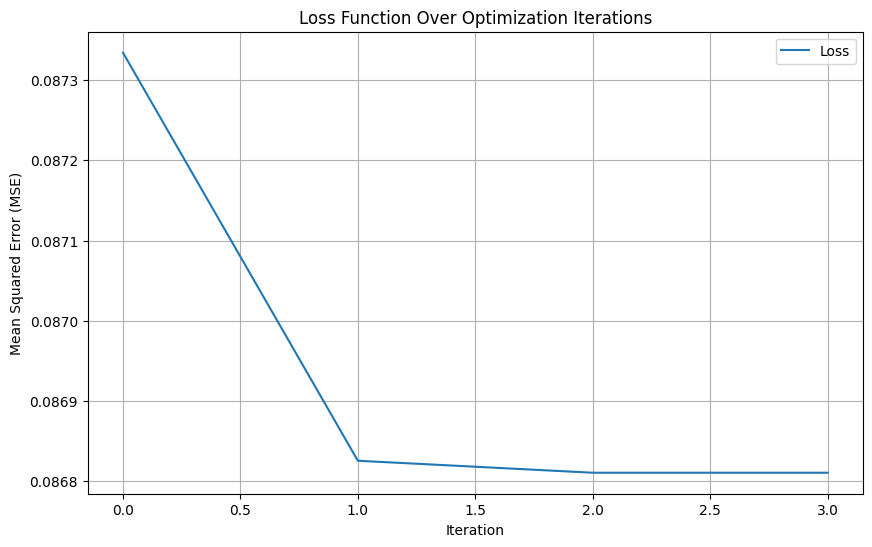

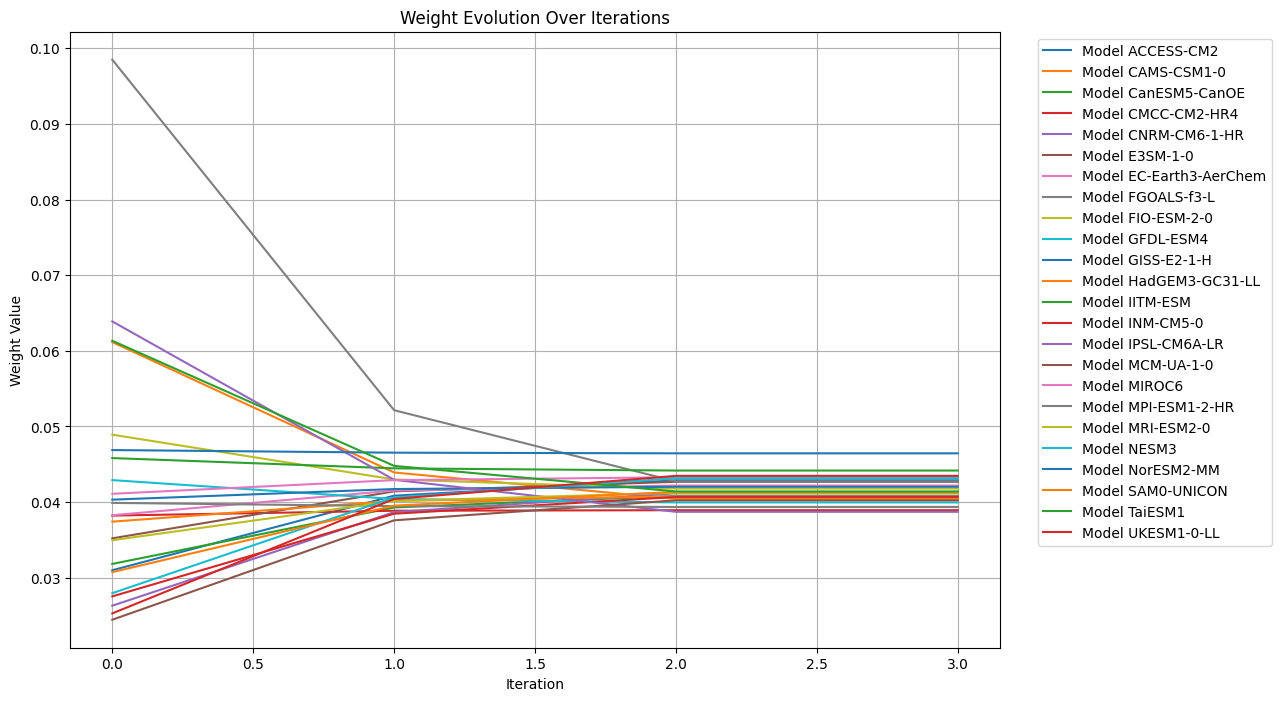

Optimal weights: [0.0428917  0.04042934 0.04083013 0.03893458 0.0411751  0.04269115
 0.04219206 0.04274066 0.04179364 0.03996452 0.04203316 0.04074762
 0.04417684 0.04068648 0.03872197 0.04024067 0.04329135 0.03936661
 0.04123645 0.04315902 0.04645279 0.04135566 0.04141236 0.04347617]


In [16]:

# Plot the loss function over iterations
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Loss')
plt.title('Loss Function Over Optimization Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the weight evolution
weight_history = np.array(weight_history)

plt.figure(figsize=(12, 8))
for i in range(weight_history.shape[1]):
    plt.plot(weight_history[:, i], label=f'Model {df["Model"].iloc[i]}')

plt.title('Weight Evolution Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Weight Value')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()

print("Optimal weights:", optimal_weights)


# Tensor Data and U-Net CNN

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model



In [19]:
def visualize_predictions(model, X, y):
    # Predict on training data
    predictions = model.predict(X)

    # Visualize some results
    plt.figure(figsize=(12, 6))
    
    # Input Image
    plt.subplot(1, 3, 1)
    plt.title("Input")
    plt.imshow(X[0, :, :, 0], cmap='gray')
    plt.axis('off')
    
    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(y[0, :, :, 0], cmap='gray')
    plt.axis('off')
    
    # Prediction
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(predictions[0, :, :, 0], cmap='gray')
    plt.axis('off')
    
    plt.show()




Training with learning rate: 0.001
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.1610 - loss: 0.7100
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0592 - loss: 0.4697
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0592 - loss: 3.1888
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0592 - loss: 0.5184
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0592 - loss: 0.5402
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0592 - loss: 0.5885
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0592 - loss: 0.5933
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0592 - loss: 0.5828
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0592 - loss: 0.5598
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0592 - loss: 0.5224

Training with learning rate: 0.0005
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.1587 - loss: 0.7092
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━

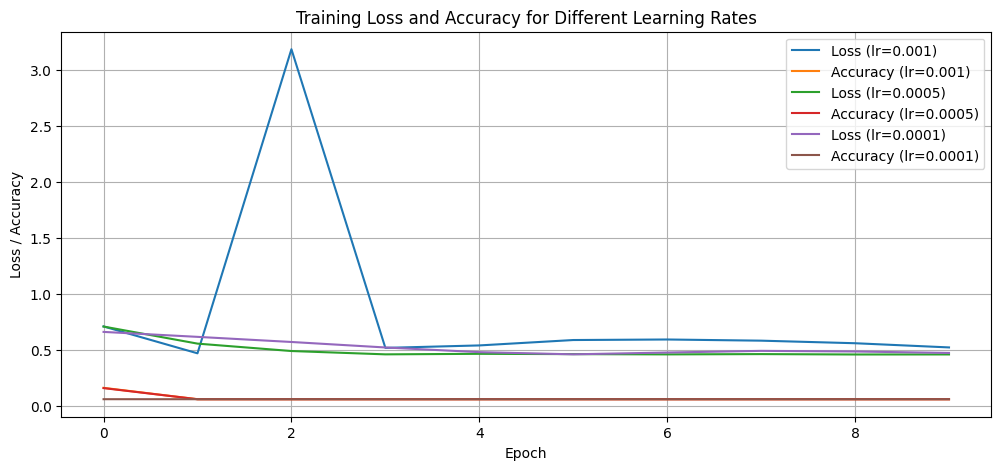

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


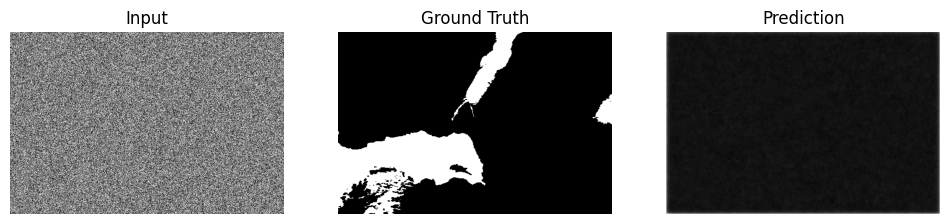

In [20]:
# Define the U-Net model
def unet_model(input_shape):
    inputs = Input(input_shape)
    
    # Contracting path
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Expansive path
    up4 = UpSampling2D((2, 2))(conv3)
    up4 = concatenate([up4, conv2], axis=-1)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up5 = UpSampling2D((2, 2))(conv4)
    up5 = concatenate([up5, conv1], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def visualize_predictions(model, X, y):
    # Predict on training data
    predictions = model.predict(X)

    # Visualize some results
    plt.figure(figsize=(12, 6))
    
    # Input Image
    plt.subplot(1, 3, 1)
    plt.title("Input")
    plt.imshow(X[0, :, :, 0], cmap='gray')
    plt.axis('off')
    
    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(y[0, :, :, 0], cmap='gray')
    plt.axis('off')
    
    # Prediction
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(predictions[0, :, :, 0], cmap='gray')
    plt.axis('off')
    
    plt.show()

# Prepare the data
X = np.stack([model[0] for model in averaged_models_data_name], axis=-1)  # Shape: (1, 400, 600, 24)
X = np.expand_dims(X, axis=0)  # Shape: (1, 400, 600, 24)
y = get_chirps_data(CHIRPS_DATA_PATH)  # Shape: (400, 600)
y = np.expand_dims(y, axis=-1)  # Shape: (400, 600, 1)
y = np.expand_dims(y, axis=0)  # Shape: (1, 400, 600, 1)

# Normalize the data
X = X / np.max(X)  # Normalize input to range [0, 1]
y = y / np.max(y)  # Normalize target to range [0, 1]

# Initialize learning rates for testing
learning_rates = [0.001, 0.0005, 0.0001]
history_per_lr = {}

# Loop over different learning rates
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = unet_model((400, 600, 24))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X, y, batch_size=1, epochs=10, validation_split=0)
    history_per_lr[lr] = history.history
    
    # Visualize predictions after training

# Plot the loss and accuracy for each learning rate
plt.figure(figsize=(12, 5))

for lr in learning_rates:
    plt.plot(history_per_lr[lr]['loss'], label=f'Loss (lr={lr})')
    plt.plot(history_per_lr[lr]['accuracy'], label=f'Accuracy (lr={lr})')

plt.title('Training Loss and Accuracy for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.grid()
plt.show()
visualize_predictions(model, X, y)

